In [0]:
!pip install pycox
!pip install torchtuples
!pip install sk-video

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/My Drive/Mallat')
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import HTML
import skvideo.io
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import torchtuples as tt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Scan and Mask 3D Images Visualization

In [154]:
train_path = 'train_data/'
test_path = 'test_data/'
archive = np.load(train_path+'images/patient_305.npz')
scan = archive['scan'] 
mask = archive['mask'] 
print(scan.shape, mask.shape, np.unique(scan), np.unique(mask))

     |████████████████████████████████| 2.3MB 8.8MB/s 
(92, 92, 92) (92, 92, 92) [-1024 -1023 -1022 ...  1013  1021  1027] [False  True]


In [0]:
train_labels = pd.read_csv('y_train.csv', index_col=0)
train_labels.head()

,SurvivalTime,Event
PatientID,,
202,1378,0
371,379,1
246,573,1
240,959,0
284,2119,0


In [0]:
def rescale(scan, mask):
    """Scales scan and mask to 0 - 255 for later plots"""
    maxi = np.max(scan) # 1023
    mini = np.min(scan) # -1024

    scaled_scan = 255*(1.*scan-mini)/(maxi-mini)
    scaled_scan = scaled_scan.astype(int)

    scaled_mask = mask.astype(int)*255
    
    return scaled_scan, scaled_mask

def display_video(name):
    """Display video"""
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video width="320" height="240" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

scaled_scan, scaled_mask = rescale(scan, mask)

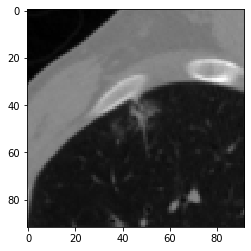

In [0]:
import matplotlib.pyplot as plt
plt.imshow(scaled_scan[:,:,50], cmap='gray')
plt.show()

In [0]:
skvideo.io.vwrite('CT_SCAN.mp4', scaled_scan)
HTML(display_video('CT_SCAN.mp4'))

In [0]:
skvideo.io.vwrite('MASK.mp4', scaled_mask)
HTML(display_video('MASK.mp4'))

# 2D Discriminative Slice Extraction

In [0]:
def extract_slice(scan, mask, dim=None):
    """Extract the 2D slice of the scan with maximum number of tumor pixels, 
    along a specified dimension or accross all"""

    int_mask = mask.astype(int)
    n = mask.shape[0] # 92
    d = len(mask.shape) # 3
    best_count = 0
    best_idx = (None, None)

    if dim is None: # get best slice across all dim
      for i in range(d):
        axis = tuple(j for j in range(d) if j !=i)
        counts_axis = np.sum(int_mask, axis = axis)
        best_idx_axis = np.argmax(counts_axis)
        best_count_axis = counts_axis[best_idx_axis]
        if best_count_axis > best_count:
          best_count = best_count_axis
          best_idx = (i, best_idx_axis)
    else: # get best slice on the argument dim
        axis = tuple(j for j in range(d) if j !=dim)
        counts_axis = np.sum(int_mask, axis = axis)
        best_idx_axis = np.argmax(counts_axis)
        best_count = counts_axis[best_idx_axis]
        best_idx = (dim, best_idx_axis)

    best_dim = best_idx[0]
    # print(best_dim, best_idx, best_count)
    if best_dim==0:
      best_slice = scan[best_idx[1],:,:]
    elif best_dim==1:
      best_slice = scan[:,best_idx[1],:]
    elif best_dim==2:
      best_slice = scan[:,:,best_idx[1]]
    return best_slice

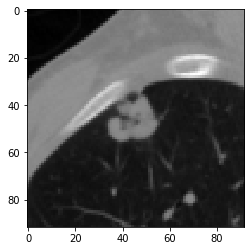

In [0]:
best_slice = extract_slice(scan, mask)
plt.imshow(best_slice, cmap='gray')
plt.show()

# Feature Extraction

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models

class Model(nn.Module):
  """Extract 512 features with Resnet18 from a 2D image"""
  def __init__(self):
    super(Model, self).__init__()
    resnet18 = models.resnet18(pretrained = True)
    self.resnet = nn.Sequential(*list(resnet18.children())[:-1]) # remove classifier
  
  def forward(self, x):
    return self.resnet(x)

In [0]:
def extract_features(model, embed_dim, path, dim):
  """Extract features using model that has embeddings of size embed_dim for all
  images in path along dim"""
  filenames = os.listdir(path)
  features = {}

  for file in filenames:
    # Read archive
    archive = np.load(path+'/'+file)
    scan = archive['scan'] 
    mask = archive['mask'] 
    if np.sum(mask.astype(int)) == 0: # no tumor 
      features[file] = tuple(np.zeros(embed_dim))
      continue

    # Extract slice, normalize, convert to RGB and to torch tensor
    best_slice = extract_slice(scan, mask, dim)
    maxi = np.max(best_slice) # 1023
    mini = np.min(best_slice) # -1024
    scaled_slice = (1.*best_slice-mini)/(maxi-mini)
    rgb_slice =  np.repeat(scaled_slice[:,:,np.newaxis], 3, -1)
    img = torch.from_numpy(rgb_slice)
    img = img.type('torch.FloatTensor')
    img = img.view(1,3,92,92)
    img = img.to(device)

    # Extract Features
    with torch.no_grad():
        features_img = model(img)
    features[file] = tuple(features_img.flatten().cpu().detach().numpy())
  return features

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = Model().to(device)

for i in range(3):
  train_features = extract_features(model, 512, train_path+'/images', i)
  with open('train_features_'+str(i)+'.pkl', 'wb') as f:
    pickle.dump(train_features, f)
train_features = extract_features(model, 512, train_path+'/images', None)
with open('train_features.pkl', 'wb') as f:
    pickle.dump(train_features, f)

for i in range(3):
  test_features = extract_features(model, 512, test_path+'/images', i)
  with open('test_features_'+str(i)+'.pkl', 'wb') as f:
    pickle.dump(test_features, f)

test_features = extract_features(model, 512, test_path+'/images', None)
with open('test_features.pkl', 'wb') as f:
    pickle.dump(test_features, f)

# Finetuning with negative log likelihood loss

In [0]:
def preprocess_images(ids, path):
  """
  Extract from images best slices and outputs a numpy array of shape 1,3,92,92
  """
  filenames = ['patient_'+'{0:03d}'.format(n)+'.npz' for n in ids]
  slices = np.zeros((len(filenames),3,92,92))

  for i, file in enumerate(filenames):
    # Read archive
    archive = np.load(path+file)
    scan = archive['scan'] 
    mask = archive['mask'] 
    if np.sum(mask.astype(int)) == 0: # no tumor 
      slices[i] = np.zeros((1,3,92,92))
      continue

    # Extract slice, normalize, convert to RGB and to torch tensor
    best_slice = extract_slice(scan, mask)
    maxi = np.max(best_slice) # 1023
    mini = np.min(best_slice) # -1024
    scaled_slice = (1.*best_slice-mini)/(maxi-mini)
    rgb_slice =  np.repeat(scaled_slice[:,:,np.newaxis], 3, -1)
    rgb_slice = rgb_slice.reshape((1,3,92,92))
    slices[i] = rgb_slice
  return slices

def preprocess_images2(ids, path):
  """
  Extract from images best slices and outputs a numpy array of shape 1,1,92,92 (NO REPEAT)
  """
  filenames = ['patient_'+'{0:03d}'.format(n)+'.npz' for n in ids]
  slices = np.zeros((len(filenames),1,92,92))

  for i, file in enumerate(filenames):
    # Read archive
    archive = np.load(path+file)
    scan = archive['scan'] 
    mask = archive['mask'] 
    if np.sum(mask.astype(int)) == 0: # no tumor 
      slices[i] = np.zeros((1,1,92,92))
      continue

    # Extract slice, normalize, convert to RGB and to torch tensor
    best_slice = extract_slice(scan, mask)
    maxi = np.max(best_slice) # 1023
    mini = np.min(best_slice) # -1024
    scaled_slice = (1.*best_slice-mini)/(maxi-mini)
    rgb_slice = scaled_slice.reshape((1,1,92,92))
    slices[i] = rgb_slice
  return slices

In [0]:
# TRY OF MIXING WITH OTHER FEATURES
traindf = pd.read_csv('input_train.csv')
train_labels = pd.read_csv('y_train.csv')
traindf = pd.merge(traindf, train_labels, on = 'PatientID')
testdf = pd.read_csv('input_test.csv', index_col = 0)

In [0]:
# Get data in the right format
# ids = traindf.index.values
ids = traindf['PatientID']
slices = preprocess_images(ids, 'train_data/images/') 
times = traindf['SurvivalTime'].values
events = traindf['Event'].values

In [0]:
# TRY OF MIXING WITH OTHER FEATURES
radiomics_features = ['original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio',
                      'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy', 'original_glcm_Id',
                      'original_glcm_Idm']
clinical_features = ['SourceDataset_l1', 'Nstage']
features_names = radiomics_features + clinical_features
other_features = np.zeros((len(traindf), len(features_names)))
for i, f in enumerate(features_names):
  other_features[:,i] = traindf[f]

In [352]:
# Train Val split
x_train, x_val, times_train, times_val, events_train, events_val, z_train, z_val = train_test_split(slices, times, events, other_features, test_size = 0.25)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
x_train = torch.from_numpy(x_train).type(torch.FloatTensor).to(device)
x_val = torch.from_numpy(x_val).type(torch.FloatTensor).to(device)

times_train = torch.from_numpy(times_train).to(device)
times_val = torch.from_numpy(times_val).to(device)

events_train = torch.from_numpy(events_train).to(device)
events_val = torch.from_numpy(events_val).to(device)

y_train = (times_train, events_train)
y_val = (times_val, events_val)

# TRY OF MIXING WITH OTHER FEATURES
"""z_train = torch.from_numpy(z_train).type(torch.FloatTensor).to(device)
z_val = torch.from_numpy(z_val).type(torch.FloatTensor).to(device)

x_train = torch.cat([x_train.view(-1,3*92*92),z_train], axis = 1)
x_val = torch.cat([x_val.view(-1,3*92*92),z_val], axis = 1)"""

'z_train = torch.from_numpy(z_train).type(torch.FloatTensor).to(device)\nz_val = torch.from_numpy(z_val).type(torch.FloatTensor).to(device)\n\nx_train = torch.cat([x_train.view(-1,3*92*92),z_train], axis = 1)\nx_val = torch.cat([x_val.view(-1,3*92*92),z_val], axis = 1)'

In [0]:
class Net(nn.Module):
  """Resnet + MLP model"""
  def __init__(self, H1 = 128, H2 = 64): # Z = 8
    super(Net, self).__init__()
    resnet = models.resnet18(pretrained = True)
    self.resnet = nn.Sequential(*list(resnet.children())[:-1]) # remove classifier
    for child in list(self.resnet.children())[:-3]: # freeze first layers
          for param in child.parameters():
              param.requires_grad = False
    self.mlp = nn.Sequential(nn.Linear(512, H1), 
                             nn.ReLU(), 
                             nn.Dropout(0.5), 
                             nn.Linear(H1, H2), 
                             nn.ReLU(),
                             nn.Dropout(0.5))
    self.fc = nn.Sequential(nn.Linear(H2, 1, bias = False)) # risk computation

    # TRY OF MIXING WITH OTHER FEATURES
    """self.mlp2 = nn.Sequential(nn.Linear(Z, 128), 
                             nn.ReLU(), 
                             nn.Dropout(0.2), 
                             nn.Linear(128, 1, bias = False))"""
  
  def forward(self, x):
    # TRY OF MIXING WITH OTHER FEATURES x, y = x[:,:-8], x[:,-8:]
    # x = x.view(-1,3, 92, 92)
    x = self.resnet(x)
    x = x.view(-1,512)
    x = self.mlp(x)
    # TRY OF MIXING WITH OTHER FEATURES x = torch.exp(self.fc(x)+self.mlp2(y)) # hazard
    x = torch.exp(self.fc(x))
    return x

class ConvNet(nn.Module):
  """1-greyscale CNN"""
  def __init__(self, H1 = 128, H2 = 16):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 4, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(4, 8, 5)
    self.dropout = nn.Dropout(0.5)
    self.fc1 = nn.Linear(8 * 5 * 5, H1)
    self.fc2 = nn.Linear(H1, H2)
    self.fc3 = nn.Linear(H2, 1)
  
  def forward(self, x, y):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 8 * 5 * 5)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = torch.exp(self.fc3(x))
    return x

class MiniNet(nn.Module):
  """Debug Model"""
  def __init__(self):
    super(MiniNet, self).__init__()
    self.net = torch.nn.Sequential(nn.Linear(25392, 256),nn.ReLU(),nn.BatchNorm1d(256),
                                   nn.Dropout(0.3),nn.Linear(256, 32),nn.ReLU(),
                                   nn.BatchNorm1d(32),nn.Dropout(0.3),nn.Linear(32, 1))
  
  def forward(self, x):
    x = x.view(-1,25392)
    return self.net(x)

In [0]:
net = Net()
# optimizer = tt.optim.Adam 
# (params = net.parameters(),lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# {'params': net.mlp2.parameters(), 'lr': 1e-2} params = [{'params': net.mlp.parameters(), 'lr': 1e-3},{'params': net.resnet.parameters()},{'params': net.fc.parameters(), 'lr': 1e-3},]
optimizer = tt.optim.SGD(lr=1e-3, momentum=0.9, weight_decay=3e-4, nesterov=True)
model = CoxPH(net, optimizer = optimizer, device = device)

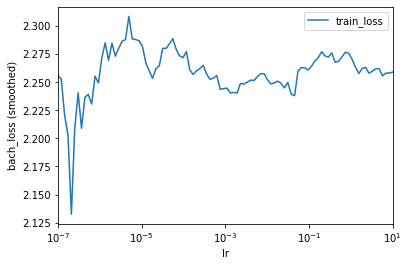

0.0001


In [368]:
# Get best learning rate - OFTEN OVERESTIMATED
batch_size = 15 # TAKE A INT DIVIDING DATA LENGTHS OR DEFINE PROPER TORCH DATALOADERS
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
lrfinder.plot()
plt.show()
print(lrfinder.get_best_lr())

0:	[1s / 1s],		train_loss: 2.3017,	val_loss: 2.2175
1:	[1s / 3s],		train_loss: 2.2902,	val_loss: 2.2106
2:	[1s / 4s],		train_loss: 2.2823,	val_loss: 2.1928
3:	[1s / 6s],		train_loss: 2.3074,	val_loss: 2.1813
4:	[1s / 7s],		train_loss: 2.3012,	val_loss: 2.1797
5:	[1s / 9s],		train_loss: 2.2880,	val_loss: 2.1804
6:	[1s / 10s],		train_loss: 2.2558,	val_loss: 2.1804
7:	[1s / 12s],		train_loss: 2.2518,	val_loss: 2.1775
8:	[1s / 13s],		train_loss: 2.2849,	val_loss: 2.1792
9:	[1s / 15s],		train_loss: 2.2842,	val_loss: 2.1778
10:	[1s / 16s],		train_loss: 2.2267,	val_loss: 2.1743
11:	[1s / 18s],		train_loss: 2.2537,	val_loss: 2.1729
12:	[1s / 19s],		train_loss: 2.2609,	val_loss: 2.1734
13:	[1s / 20s],		train_loss: 2.2814,	val_loss: 2.1729
14:	[1s / 22s],		train_loss: 2.2193,	val_loss: 2.1739
15:	[1s / 23s],		train_loss: 2.2614,	val_loss: 2.1720
16:	[1s / 25s],		train_loss: 2.2382,	val_loss: 2.1692
17:	[1s / 26s],		train_loss: 2.2159,	val_loss: 2.1727
18:	[1s / 28s],		train_loss: 2.2507,	val_los

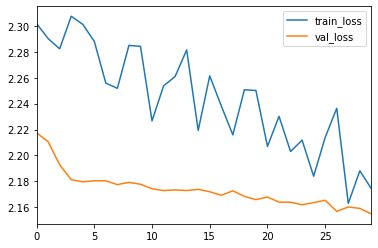

-3.703059673309326


In [369]:
# Training 
model.optimizer.set_lr(0.0001)
batch_size = 15
epochs = 30
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=(x_val,y_val), val_batch_size=batch_size)
log.plot()
plt.show()
print(model.partial_log_likelihood(*(x_val,y_val)).mean())

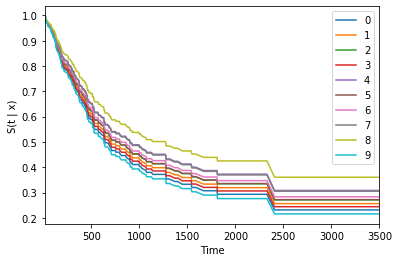

In [370]:
# Validation predictions of survival
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_val)
surv.iloc[:,:10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

0.6248715313463515
0.5973629584603997


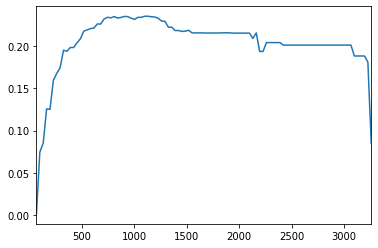

In [371]:
# Evaluation on validation set
dur = times_val.cpu().detach().numpy()
eve = events_val.cpu().detach().numpy()
ev = EvalSurv(surv, dur, eve, censor_surv='km')
print(ev.concordance_td())
time_grid = np.linspace(dur.min(), dur.max(), 100)
_ = ev.brier_score(time_grid).plot()
print(ev.integrated_nbll(time_grid))

In [0]:
# Get test data
test_idx = pd.read_csv('random_submission.csv', index_col=0)
test_ids = test_idx.index.values
test_slices = preprocess_images(test_ids, 'test_data/images/') 
x_test = torch.from_numpy(test_slices).type(torch.FloatTensor).to(device)

In [0]:
# Test predictions
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
surv.iloc[:,:10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')